# Learning Blackjack

Here is the second part of my experimentation with reinforcement learning, this time focusing on Monte Carlo methods and based on the following article: http://outlace.com/Reinforcement-Learning-Part-2/

The problem that I'll work on is training an algorithm to play Blackjack, learning to make better decisions as it goes (as opposed to the brute-force approach of calculating every possible outcome, and using this knowledge to make decisions based on the known cards).

Basically, I want to train the computer to choose whether to hit or stay, given the combination of cards that are visible, which I'll refer to as the state. By keeping track of the outcomes for different actions and card combinations, the algorithm can learn what the best action is for a given state.

The state will be represented by a tuple, with the player's hand (value of cards, and boolena for useable ace) the dealer's hand (same elements as player's hand), and the status of the state (in progress, win, loss, draw).

In [28]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

First, I set up the functions necessary for our Blackjack game.

In [18]:
def rand_card():
    #chooses a card at random, value between 1 and 13, setting face cards equal to 10
    card = random.randint(1,13)
    if card > 10:
        card = 10
    return(card)

def useable_ace(hand):
    # determines if the hand contains a useable ace, i.e. if it can also be used as an 11
    # reads in a hand, which is a tuple
    val, ace = hand
    return(ace and ((val+10) <= 21))

def handvalue(hand):
    # calculates the value of a hand, testing for a useable ace
    val, ace = hand
    if (useable_ace(hand)):
        return(val+10)
    else:
        return(val)
    
def add_card(hand, card):
    # add a new card and update player's hand
    val, ace = hand
    if (card == 1):
        ace = True
    return (val+card, ace)

def dealer(dealer_hand):
    # add cards to the dealer's hand until 17 is reached
    while(handvalue(dealer_hand)<17):
        dealer_hand = add_card(dealer_hand, rand_card())
    return(dealer_hand)

def play(state, dec):
    # executes a round of play for a given state and decision from the player
    player_hand = state[0]
    dealer_hand = state[1]
    if dec == 0: #choose to stay
        dealer_hand = dealer(dealer_hand)
        player_tot = handvalue(player_hand)
        dealer_tot = handvalue(dealer_hand)
        status = 1 # in progress
        if (dealer_tot > 21):
            status = 2 # player wins
        elif (dealer_tot == player_tot):
            status = 3 #draw
        elif (dealer_tot < player_tot):
            status = 2 # player wins
        elif (dealer_tot > player_tot):
            status = 4 # player loses
        
    elif dec == 1: #choose to hit
        player_hand = add_card(player_hand, rand_card())
        dealer_hand_ = dealer(dealer_hand)
        player_tot = handvalue(player_hand)
        dealer_tot = handvalue(dealer_hand_)
        status = 1 # in progress
        if (player_tot == 21):
            if(dealer_tot == 21):
                status = 3 #draw
            else:
                status = 2 #player wins
        elif (player_tot > 21):
            status = 4 # player loses
        elif (player_tot < 21):
            status = 1 # play continues
            
    state = (player_hand, dealer_hand, status)
    return(state)
        
def startGame():
    # starts a new game with a random initial state
    status = 1
    player_hand = add_card((0,False), rand_card())
    player_hand = add_card(player_hand, rand_card())
    dealer_hand = add_card((0,False), rand_card())
    if(handvalue(player_hand)==21):
        if(handvalue(dealer_hand)!=21):
            status = 2 # player wins
        else:
            status = 3 # draw
    state = (player_hand, dealer_hand, status)
    return(state)

The game is now ready to play! Next, I need to create a player algorithm that learns as it plays. Let's run a test game so we know what our virtual player will need to do.

In [19]:
state = startGame()
print(state)

while (state[2]==1):
    dec = raw_input('Type stay or hit:')
    if (dec == 'stay'):
        state = play(state, 0)
    elif (dec == 'hit'):
        state = play(state, 1)
    print(state)


((20, False), (7, False), 1)
Type stay or hit:stay
((20, False), (8, True), 2)


It's pretty simple, the player just needs to choose to stay or hit, given the state. But how to decide? That's where the reinforcement learning comes in. 

Below, the functions needed to run the Monte Carlo algorithm are defined: initializing a list with all possible states, creating a lookup table to contain the average outcome for each state, a table to track the number of times each state has been seen, and a function to return the expected value for a stay or hit action, given the state.

In [64]:
def init_state_space():
    # initialize a state space with all possible states of player hand, useable ace, dealer card
    states = []
    for dealer_card in range(1,11):
        for hand_val in range(11,22):
            states.append((hand_val, True, dealer_card))
            states.append((hand_val, False, dealer_card))
    return(states)

def init_state_actions(states):
    # initialize a dictionary as a look-up table for each state and action
    av = {}
    for state in states:
        av[(state, 0)] = 0.0 # average outcome for state, stay
        av[(state, 1)] = 0.0 # average outcome for state, hit
    return(av)

def init_count(state_actions):
    # initialize a dictionary to keep track of how many times each state and action pair is chosen
    counts = {}
    for pair in state_actions:
        counts[pair] = 0
    return(counts)

def calc_reward(outcome):
    #converts outcome to reward of -1 (loss), 0 (draw), 1 (win)
    return(3.0-outcome)
    
def update_Qtable(av_table, av_count, returns):
    #recalculates the average reward for the table given recent events
    for key in returns:
        av_table[key] = av_table[key]+(1.0/av_count[key])*(returns[key]-av_table[key])
    return(av_table)

def Qval(state, av_table):
    # return the expected value for a given state for each action 
    stay = av_table[(state,0)]
    hit = av_table[(state,1)]
    return(np.array([stay,hit]))

def get_mod_state(state):
    # returns a modified state for use in our algorithm
    player_hand, dealer_hand, status = state
    player_val, player_ace = player_hand
    return (player_val, player_ace, dealer_hand[0])


Now it's time to run the Monte Carlo algorithm to train the Blackjack model (i.e. to fill in the lookup table with results from many, many games). 

In [70]:
n_games = 5000000
eps = 0.1

state_space = init_state_space()
av_table = init_state_actions(state_space)
av_count = init_count(av_table)

for game in range(n_games):
    # start a new game
    state = startGame()
    player_hand, dealer_hand, status = state
    # add cards to the player's hand until the total is at least 11
    while player_hand[0] < 11:
        player_hand = add_card(player_hand, rand_card())
        state = (player_hand, dealer_hand, status)
    mod_state = get_mod_state(state)
    
    returns = {}
    #check to see if game is ongoing
    while(state[2]==1):
        act_probs = Qval(mod_state, av_table)
        # choose best action, with random choice set by eps
        if (random.random() < eps):
            action = random.randint(0,1) # choose random action
        else:
            action = np.argmax(act_probs) # choose best action given past outcomes
        state_action = ((mod_state, action))
        returns[state_action] = 0
        av_count[state_action] +=1 # increment counter
        state = play(state, action)
        mod_state = get_mod_state(state)
        
    for key in returns:
        returns[key] = calc_reward(state[2])
    av_table = update_Qtable(av_table, av_count, returns)
print("Done")

Done


In [180]:
X = range(11,22)
Y = range(1,11)
dif_uAce = np.zeros([len(Y)+1,len(X)+1])
dif_nAce = np.zeros([len(Y)+1,len(X)+1])
max_uAce = np.zeros([len(Y)+1,len(X)+1])
max_nAce = np.zeros([len(Y)+1,len(X)+1])

for n,x in enumerate(X):
    for m,y in enumerate(Y):
        dif_uAce[m,n]=(av_table[((x,True,y), 1)]-av_table[((x,True,y), 0)])
        dif_nAce[m,n]=(av_table[((x,False,y), 1)]-av_table[((x,False,y), 0)])
        max_uAce[m,n]=max(av_table[((x,True,y), 1)],av_table[((x,True,y), 0)])
        max_nAce[m,n]=max(av_table[((x,False,y), 1)],av_table[((x,False,y), 0)])
X.append(23)
Y.append(12)

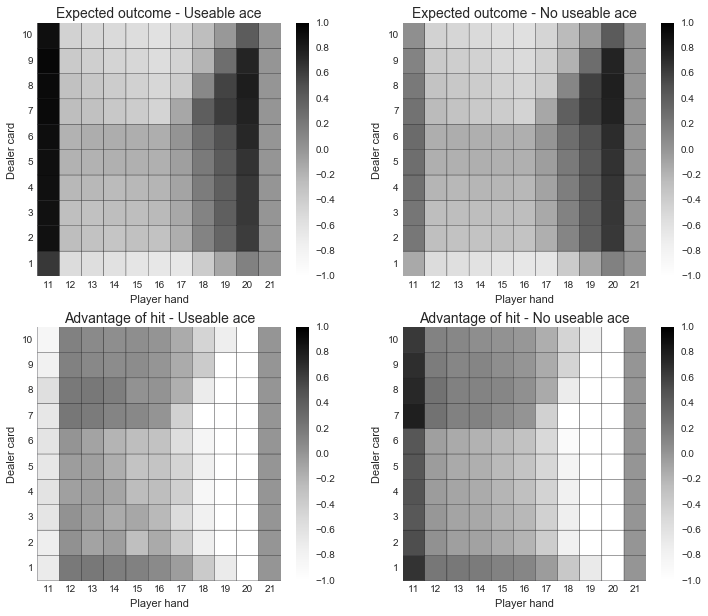

In [218]:
import matplotlib.ticker as ticker
x_tick_loc = [x+0.5 for x in X]
y_tick_loc = [y+0.5 for y in Y]

plt.figure(figsize = (12,10))
ax1 = plt.subplot(221)
plt.pcolor(X,Y,max_uAce, vmin = -1, vmax = 1, edgecolors = 'k')
plt.xlabel('Player hand')
plt.ylabel('Dealer card')
plt.title('Expected outcome - Useable ace', fontsize = 14)
plt.ylim([1,11])
plt.xlim([11,22])
ax1.xaxis.set_major_formatter(ticker.NullFormatter()) 
ax1.xaxis.set_minor_locator(ticker.FixedLocator(x_tick_loc))
ax1.xaxis.set_minor_formatter(ticker.FixedFormatter(X))
ax1.yaxis.set_major_formatter(ticker.NullFormatter()) 
ax1.yaxis.set_minor_locator(ticker.FixedLocator(y_tick_loc))
ax1.yaxis.set_minor_formatter(ticker.FixedFormatter(Y))
plt.colorbar()

ax2 = plt.subplot(222)
plt.pcolor(X,Y,max_nAce, vmin = -1, vmax = 1, edgecolors = 'k')
plt.xlabel('Player hand')
plt.ylabel('Dealer card')
plt.title('Expected outcome - No useable ace', fontsize = 14)
plt.ylim([1,11])
plt.xlim([11,22])
ax2.xaxis.set_major_formatter(ticker.NullFormatter()) 
ax2.xaxis.set_minor_locator(ticker.FixedLocator(x_tick_loc))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(X))
ax2.yaxis.set_major_formatter(ticker.NullFormatter()) 
ax2.yaxis.set_minor_locator(ticker.FixedLocator(y_tick_loc))
ax2.yaxis.set_minor_formatter(ticker.FixedFormatter(Y))
plt.colorbar()

ax3 = plt.subplot(223)
plt.pcolor(X,Y,dif_uAce, vmin = -1, vmax = 1, edgecolors = 'k')
plt.xlabel('Player hand')
plt.ylabel('Dealer card')
plt.title('Advantage of hit - Useable ace', fontsize = 14)
plt.ylim([1,11])
plt.xlim([11,22])
ax3.xaxis.set_major_formatter(ticker.NullFormatter()) 
ax3.xaxis.set_minor_locator(ticker.FixedLocator(x_tick_loc))
ax3.xaxis.set_minor_formatter(ticker.FixedFormatter(X))
ax3.yaxis.set_major_formatter(ticker.NullFormatter()) 
ax3.yaxis.set_minor_locator(ticker.FixedLocator(y_tick_loc))
ax3.yaxis.set_minor_formatter(ticker.FixedFormatter(Y))
plt.colorbar()

ax4 = plt.subplot(224)
plt.pcolor(X,Y,dif_nAce, vmin = -1, vmax = 1, edgecolors = 'k')
plt.xlabel('Player hand')
plt.ylabel('Dealer card')
plt.title('Advantage of hit - No useable ace', fontsize = 14)
plt.ylim([1,11])
plt.xlim([11,22])
ax4.xaxis.set_major_formatter(ticker.NullFormatter()) 
ax4.xaxis.set_minor_locator(ticker.FixedLocator(x_tick_loc))
ax4.xaxis.set_minor_formatter(ticker.FixedFormatter(X))
ax4.yaxis.set_major_formatter(ticker.NullFormatter()) 
ax4.yaxis.set_minor_locator(ticker.FixedLocator(y_tick_loc))
ax4.yaxis.set_minor_formatter(ticker.FixedFormatter(Y))
plt.colorbar()
plt.show()

It's a little hard to interpret the plots above. We can also make a simple table that shows whether it's better (according to the above simulation) to hit or stay for each state. These tables illustrate how the algorithm will decide to play future hands, given what it has learned.

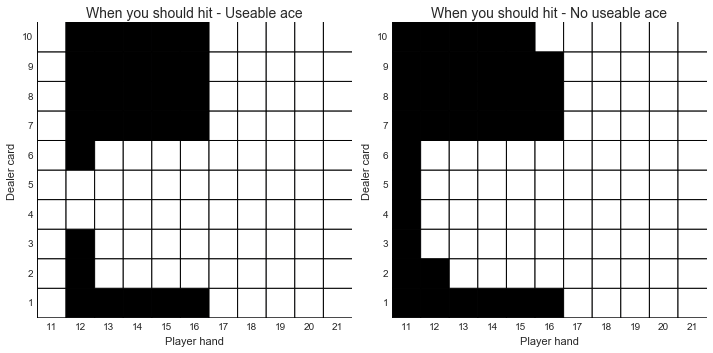

In [214]:
hit_map_uAce = dif_uAce > 0
hit_map_nAce = dif_nAce > 0


plt.figure(figsize = [10,5])
ax1 = plt.subplot(121)
ax1.pcolor(X,Y,hit_map_uAce, edgecolors = 'k', linewidths=1)
ax1.xaxis.set_major_formatter(ticker.NullFormatter()) 
ax1.xaxis.set_minor_locator(ticker.FixedLocator(x_tick_loc))
ax1.xaxis.set_minor_formatter(ticker.FixedFormatter(X))
ax1.yaxis.set_major_formatter(ticker.NullFormatter()) 
ax1.yaxis.set_minor_locator(ticker.FixedLocator(y_tick_loc))
ax1.yaxis.set_minor_formatter(ticker.FixedFormatter(Y))
ax1.set_ylim([1,11])
ax1.set_xlim([11,22])
ax1.set_title('When you should hit - Useable ace', fontsize = 14)
ax1.set_xlabel('Player hand')
ax1.set_ylabel('Dealer card')

ax2 = plt.subplot(122)
ax2.pcolor(X,Y,hit_map_nAce, edgecolors = 'k', linewidths=1)
ax2.xaxis.set_major_formatter(ticker.NullFormatter()) 
ax2.xaxis.set_minor_locator(ticker.FixedLocator(x_tick_loc))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(X))
ax2.yaxis.set_major_formatter(ticker.NullFormatter()) 
ax2.yaxis.set_minor_locator(ticker.FixedLocator(y_tick_loc))
ax2.yaxis.set_minor_formatter(ticker.FixedFormatter(Y))
ax2.set_ylim([1,11])
ax2.set_xlim([11,22])
ax2.set_title('When you should hit - No useable ace', fontsize = 14)
ax2.set_xlabel('Player hand')
ax2.set_ylabel('Dealer card')

plt.tight_layout()


plt.show()